In [71]:
import difflib
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [13]:
def load_dataset(dataset_dir: pd.DataFrame):
    data = []
    for fp in dataset_dir.glob("*.json"):
        with fp.open() as f:
            doc_diff = json.load(f)
        data.append(doc_diff)

    return pd.DataFrame(data)

dataset_dir = Path("./datasets/diff_corpus_small")
dataset = load_dataset(dataset_dir)
dataset.head()

,before,after,diff_text
0,"* ""[[The Lifecycle of Software Objects]]"", [[...","* ""[[The Lifecycle of Software Objects]]"", [[...","\n * ""[[The Lifecycle of Software Objects]]"",..."
1,| title = Learning with Hierarchical-Deep Mode...,| title = Learning with Hierarchical-Deep Mode...,\n | title = Learning with Hierarchical-Deep...
2,As in the ambitious moves from automatic speec...,As in the ambitious moves from automatic speec...,\n As in the ambitious moves from automatic s...
3,=== Deep neural networks ===\nA deep neural ne...,=== Deep neural networks ===\nA deep neural ne...,\n === Deep neural networks ===\n \n! A deep...
4,{{History of Greece}}\n'''Ancient Greece''' is...,{{History of Greece}}\n'''Ancient Greece''' is...,\n {{History of Greece}}\n \n! '''Ancient Gr...


In [83]:
processed_dataset[["before_len", "after_len"]].max(axis="columns")

0        920
1        312
2       1579
3       1625
4        858
        ... 
2548    1269
2549    1724
2550    2219
2551     968
2552    2704
Length: 2553, dtype: int64

In [84]:
processed_dataset = dataset.assign(
    before_len=dataset.before.str.len(),
    after_len=dataset.after.str.len(),
    diff_len=lambda df: (df.after_len - df.before_len).abs(),
    diff_len_norm=lambda df: df.diff_len / df[["before_len", "after_len"]].max(axis="columns")
)

## Distribution of Before and After Diffs

<Axes: title={'center': 'text length'}, ylabel='Frequency'>

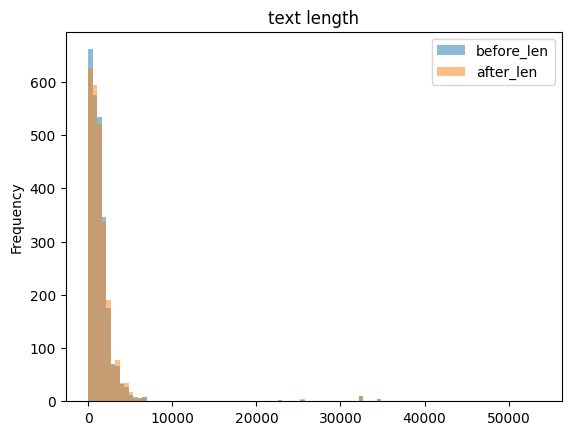

In [32]:
processed_dataset[["before_len", "after_len"]].plot.hist(bins=100, alpha=0.5, title="text length")

## Distribution of Diff Length

In character length

Text(0.5, 0, 'Diff Length (number of characters)')

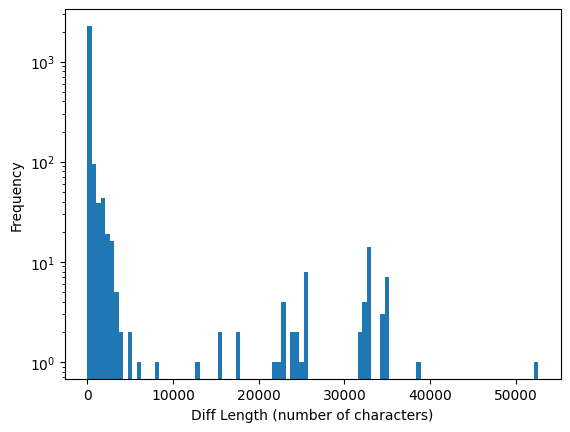

In [85]:
axes = processed_dataset['diff_len'].plot.hist(bins=100)
axes.set_yscale('log')
axes.set_xlabel('Diff Length (number of characters)')

Character length diff normalized by max(before, after)

Text(0.5, 0, 'Diff Length (number of characters)')

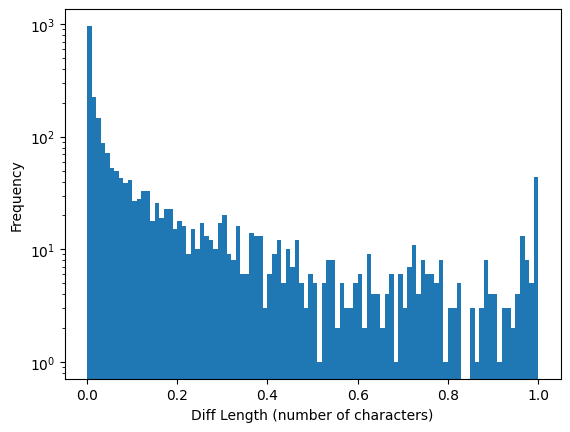

In [90]:
axes = processed_dataset['diff_len_norm'].plot.hist(bins=100)
axes.set_yscale('log')
axes.set_xlabel('Diff Length (number of characters)')

Filter out diffs with > 5000 character difference: a lot of these are introducing
spam or reverting spam.

In [79]:
i = 13
before = processed_dataset[processed_dataset.diff_len.between(30_000, 40_000)].iloc[i]["before"]
after = processed_dataset[processed_dataset.diff_len.between(30_000, 40_000)].iloc[i]["after"]
for l in difflib.unified_diff(before.splitlines(), after.splitlines()):
    print(l)

--- 

+++ 

@@ -1,182 +1 @@

-{{History of Greece}}
-'''Ancient Greece''' is the term used to describe the [[Ancient Greek|Greek]]-speaking world in ancient times. It refers not only to the geographical peninsula of modern [[Greece]], but also to  areas of [[Hellenic]] culture that were settled in ancient times by Greeks: [[Cyprus]], the [[Aegean Sea|Aegean]] coast of [[Turkey]] (then known as [[Ionia]]), [[Sicily]] and southern [[Italy]] (known as [[Magna Graecia]]), and the scattered Greek settlements on the coasts of what are now [[Albania]], [[Bulgaria]], [[Egypt]], [[Libya]], southern [[France]], southern [[Spain]], [[Catalonia]], [[Georgia (country)|Georgia]], [[Romania]], and [[Ukraine]].
-
-There are no fixed or universally agreed upon dates for the beginning or the end of the Ancient Greek period. In common usage it refers to all Greek history before the [[Roman Empire]], but historians use the term more precisely. Some writers include the periods of the Greek-speaking [[Mycen

Diffs with < 5000 character difference tend to be more meaningful

In [70]:
i = 200
before = processed_dataset[processed_dataset.diff_len.between(0, 5_000)].iloc[i]["before"]
after = processed_dataset[processed_dataset.diff_len.between(0, 5_000)].iloc[i]["after"]
for l in difflib.unified_diff(before.splitlines(), after.splitlines()):
    print(l)

--- 

+++ 

@@ -1,4 +1,8 @@

 ==The dominance of Athens==
-[[Image:www.google.com]]
-NO INFO
+[[Image:pericles.jpg|thumb|200px|Pericles]]
+The Persian Wars ushered in a century of Athenian dominance of Greek affairs. Athens was the unchallenged master of the sea, and also the leading commercial power, although Corinth remained a serious rival. The leading statesman of this time was [[Pericles]], who used the tribute paid by the members of the Delian League to build the [[Parthenon]] and other great monuments of classical Athens. By the mid 5th century the League had become an [[Athenian Empire]], symbolised by the transfer of the League's treasury from Delos to the Parthenon in [[454 BC|454 BC]]. 
+
+The wealth of Athens attracted talented people from all over Greece, and also created a wealthy leisure class who became patrons of the arts. The Athenian state also sponsored learning and the arts, particularly architecture. Athens became the centre of Greek literature, philosophy (see [[

## Modeling Strategies

- Filter out data that seems to be fixing spam.
- Include all the data, and provide more context with revision comment.